### Importing Required Libraries

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

### Dataset Processing

In [2]:
import zipfile
import os
# Unzip the main dataset file from the parent directory
zip_path = '../hindi_female_english.zip'
output_dir = 'dataset'
if os.path.exists(zip_path):
    print(f"Found zip file at: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
        print(f"Successfully extracted to '{output_dir}/'")
else:
    print(f"Error: File not found at {zip_path}")
    print("Current working directory:", os.getcwd())

Found zip file at: ../hindi_female_english.zip
Successfully extracted to 'dataset/'


### Some Analysis of the dataset

In [2]:
import os 
print(os.getcwd())

/Users/rutwik/piper-model-training/scripts


In [6]:
path_to_file = 'dataset/english/txt.done.data'

In [7]:
text = open(path_to_file, 'r',encoding='utf-8',
                 errors='ignore').read()

In [8]:
print(text[:5000])

( train_hindifullfemale_00001 " Author of the danger trail, Philip Steels, etc. " )
( train_hindifullfemale_00002 " Not at this particular case, Tom, apologized Whittemore. " )
( train_hindifullfemale_00003 " For the twentieth time that evening the two men shook hands. " )
( train_hindifullfemale_00004 " Lord, but I'm glad to see you again, Phil. " )
( train_hindifullfemale_00005 " Will we ever forget it. " )
( train_hindifullfemale_00006 " God bless 'em, I hope I'll go on seeing them forever. " )
( train_hindifullfemale_00007 " And you always want to see it in the superlative degree. " )
( train_hindifullfemale_00008 " Gad, your letter came just in time. " )
( train_hindifullfemale_00009 " He turned sharply, and faced Gregson across the table. " )
( train_hindifullfemale_00010 " I'm playing a single hand in what looks like a losing game. " )
( train_hindifullfemale_00011 " If I ever needed a fighter in my life I need one now. " )
( train_hindifullfemale_00012 " Gregson shoved back his

In [9]:
# The unique characters in the file
vocab = sorted(set(text))
print(vocab)
len(vocab)

['\n', ' ', '"', "'", '(', ')', ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'F', 'G', 'H', 'I', 'L', 'N', 'P', 'S', 'T', 'W', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


58

In [10]:
char_to_ind = {u:i for i, u in enumerate(vocab)}
ind_to_char = np.array(vocab)
encoded_text = np.array([char_to_ind[c] for c in text])
seq_len = 250
total_num_seq = len(text)//(seq_len+1)
total_num_seq

7

In [11]:
import tensorflow as tf
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

def create_seq_targets(seq):
    input_txt = seq[:-1]
    target_txt = seq[1:]
    return input_txt, target_txt

dataset = sequences.map(create_seq_targets)

### Forming the metadata.csv file

In [42]:
# Load and clean
metadata_female_fp = '../dataset/english/txt.done.data'

# Read file split by double quotes (to separate filename and transcript)
metadata_female = pd.read_csv(metadata_female_fp, sep='"', usecols=[0, 1], header=None)

# Clean filename: remove leading '(' and whitespace
metadata_female[0] = metadata_female[0].str.replace(r'\(', '', regex=True).str.strip()

# Clean transcript: remove leading/trailing whitespace
metadata_female[1] = metadata_female[1].str.strip()

# # Optional: add speaker info
# metadata_female[2] = 'female'

# Show shape and preview
print(metadata_female.shape)
metadata_female.head()


(21, 2)


,0,1
0,train_hindifullfemale_00001,"Author of the danger trail, Philip Steels, etc."
1,train_hindifullfemale_00002,"Not at this particular case, Tom, apologized W..."
2,train_hindifullfemale_00003,For the twentieth time that evening the two me...
3,train_hindifullfemale_00004,"Lord, but I'm glad to see you again, Phil."
4,train_hindifullfemale_00005,Will we ever forget it.


### Bulding the metadata.csv file

In [44]:
metadata = metadata_female
metadata.to_csv('../dataset/english/metadata.csv', sep='|', index=False, header=False)


### Preprocessing

In [1]:
import os

# 1. Define paths
# Absolute path to your dataset folder (the one containing metadata.csv)
dataset_path = 'dataset/english/reva/wav/metadata.csv'

# Absolute path to the 'src/python' folder inside the cloned piper_repo
# This is where the 'piper_train' python package lives
piper_src_path = os.path.abspath("../piper_repo/src/python")

print(f"Dataset Path: {dataset_path}")
print(f"Piper Source Path: {piper_src_path}")

# 2. Run the command with PYTHONPATH set
# This tells Python: "Look in 'piper_src_path' when I ask for 'piper_train'"
!PYTHONPATH="{piper_src_path}" python3 -m piper_train.preprocess \
  --language en-in \
  --input-dir "dataset/english/reva/wav" \
  --output-dir training_dir_reva \
  --dataset-format ljspeech \
  --single-speaker \
  --sample-rate 22050

Dataset Path: dataset/english/reva/wav/metadata.csv
Piper Source Path: /Users/rutwik/piper-model-training/piper_repo/src/python
INFO:preprocess:Single speaker dataset
INFO:preprocess:Wrote dataset config
INFO:preprocess:Processing 21 utterance(s) with 12 worker(s)


### Building the monotonic align 

In [3]:
import os
import shutil

# 1. Define input paths (Absolute path is safest here)
piper_src_path = "/Users/rutwik/piper-model-training/piper_repo/src/python"
monotonic_align_src = os.path.join(piper_src_path, "piper_train/vits/monotonic_align")

# 2. Define build directory (in current folder)
temp_build_dir = "temp_build_rutwik"

# Clean up previous build dumps if they exist to avoid nesting hell
if os.path.exists(temp_build_dir):
    shutil.rmtree(temp_build_dir)

os.makedirs(temp_build_dir, exist_ok=True)
print(f"Created {temp_build_dir}")

# 3. Copy files
for filename in ["core.pyx", "setup.py"]:
    src_file = os.path.join(monotonic_align_src, filename)
    dst_file = os.path.join(temp_build_dir, filename)
    
    if os.path.exists(src_file):
        shutil.copy(src_file, dst_file)
        print(f"Copied {filename}")
    else:
        print(f"❌ Error: Could not find {filename} at {src_file}")

# 4. Build
# Use os.chdir instead of %cd so we can track it, or just use %cd once.
%cd {temp_build_dir}

Created temp_build_rutwik
Copied core.pyx
Copied setup.py
/Users/rutwik/piper-model-training/scripts/temp_build_rutwik


### Copying the monotonic align file core.so 

In [4]:
!python3 setup.py build_ext --inplace

# Copy the compiled .so file back to the SOURCE location in piper_repo
# This is crucial so the training script can find it later
import shutil
import glob
import os

# Find the compiled file (e.g., core.cpython-311-darwin.so)
compiled_files = glob.glob("core*.so")

if compiled_files:
    src_so = compiled_files[0]
    # Destination: piper_train/vits/monotonic_align/ inside your repo
    dest_dir = os.path.join(piper_src_path, "piper_train/vits/monotonic_align")
    
    print(f"Copying {src_so} to {dest_dir}...")
    shutil.copy(src_so, dest_dir)
    print("Success: Monotonic alignment module built and installed.")
else:
    print("Error: Build failed, no .so file found.")

Compiling core.pyx because it changed.
[1/1] Cythonizing core.pyx
/Users/rutwik/miniconda3/envs/voice_training/lib/python3.11/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/rutwik/piper-model-training/scripts/temp_build_rutwik/core.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
ld: warning: duplicate -rpath '/Users/rutwik/miniconda3/envs/voice_training/lib' ignored
Copying core.cpython-311-darwin.so to /Users/rutwik/piper-model-training/piper_repo/src/python/piper_train/vits/monotonic_align...
Success: Monotonic alignment module built and installed.


### Checking if the core.so is formed

In [5]:
import sys
import shutil
import glob
import os

# 1. Run the build command
print(f" Building with: {sys.executable}")
!{sys.executable} setup.py build_ext --inplace

# 2. Copy the compiled file back to the SOURCE location
# On macOS/Linux, it produces .so files
compiled_files = glob.glob("core*.so")

if compiled_files:
    src_compiled = compiled_files[0]
    
    # Define destination path (ensure monotonic_align_src is defined)
    # If not defined in this cell, we reconstruct it:
    if 'monotonic_align_src' not in locals():
         monotonic_align_src = os.path.abspath("../piper_repo/src/python/piper_train/vits/monotonic_align")

    dest_path = os.path.join(monotonic_align_src, src_compiled)
    print(f"Copying {src_compiled} to:\n{dest_path}...")

    # Remove old file if needed
    # if os.path.exists(dest_path):
    #     os.remove(dest_path)

    shutil.copy(src_compiled, dest_path)
    print("✅ Success: Monotonic alignment module built and installed.")
else:
    print("❌ Error: Build failed, no .so file found.")

 Building with: /Users/rutwik/miniconda3/envs/voice_training/bin/python
Copying core.cpython-311-darwin.so to:
/Users/rutwik/piper-model-training/piper_repo/src/python/piper_train/vits/monotonic_align/core.cpython-311-darwin.so...
✅ Success: Monotonic alignment module built and installed.


In [27]:
import os

# Use the ABSOLUTE path to be safe regardless of current directory
monotonic_align_dir = "/Users/rutwik/piper-model-training/piper_repo/src/python/piper_train/vits/monotonic_align"

print(f"Listing contents of: {monotonic_align_dir}")

if os.path.exists(monotonic_align_dir):
    files = os.listdir(monotonic_align_dir)
    for f in files:
        print(f)
else:
    print("Directory not found.")

Listing contents of: /Users/rutwik/piper-model-training/piper_repo/src/python/piper_train/vits/monotonic_align
Makefile
__init__.py
__pycache__
core.c
setup.py
core.cpython-311-darwin.so
build
core.pyx


### Checking if the CSV file is Correct

In [17]:
import os

# 1. Force the working directory to the correct absolute path
# This fixes the issue of being stuck in "temp_build/temp_build/..."
correct_scripts_dir = "/Users/rutwik/piper-model-training/scripts"
os.chdir(correct_scripts_dir)
print(f"Fixed Current Directory: {os.getcwd()}")

# 2. Now define the path (which is right inside scripts/)
dataset_csv_path = "dataset/english/metadata.csv"
print(f"Reading: {dataset_csv_path}")

# 3. Read and print
if os.path.exists(dataset_csv_path):
    with open(dataset_csv_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            print(line.strip())
            if i == 4:
                break
else:
    print(f"Error: Still cannot find file at {dataset_csv_path}")

Fixed Current Directory: /Users/rutwik/piper-model-training/scripts
Reading: dataset/english/metadata.csv
train_hindifullfemale_00001|Author of the danger trail, Philip Steels, etc.
train_hindifullfemale_00002|Not at this particular case, Tom, apologized Whittemore.
train_hindifullfemale_00003|For the twentieth time that evening the two men shook hands.
train_hindifullfemale_00004|Lord, but I'm glad to see you again, Phil.
train_hindifullfemale_00005|Will we ever forget it.


In [2]:
# Add this cell before training to verify
import os
os.chdir('/Users/rutwik/piper-model-training/scripts')

# Check dictionary size
dict_path = "../piper/espeak-ng-data/en_dict"
dict_size = os.path.getsize(dict_path)
print(f"✅ Dictionary found: {dict_path}")
print(f"✅ Size: {dict_size:,} bytes (should be ~702KB = 718,348 bytes)")

if dict_size > 700000:
    print("✅ NEW dictionary is in place (35K+ Indian English entries)")
else:
    print("⚠️ OLD dictionary detected - need to copy the new one")

✅ Dictionary found: ../piper/espeak-ng-data/en_dict
✅ Size: 718,348 bytes (should be ~702KB = 718,348 bytes)
✅ NEW dictionary is in place (35K+ Indian English entries)


In [2]:
import os
import torch
import fileinput

# 1. Move to the scripts directory
os.chdir('/Users/rutwik/piper-model-training/scripts')
print(f"Working Directory: {os.getcwd()}")

# 2. Setup parameters
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
devices = torch.cuda.device_count() if torch.cuda.is_available() else 1
print(f"🚀 Training on {devices} {accelerator}(s)")

piper_src_path = os.path.abspath("../piper_repo/src/python")
checkpoint_path = "checkpoints/lj-med_1000.ckpt"
# checkpoint_path = "training_dir_reva/lightning_logs/version_6/checkpoints/epoch=3000-step=1068.ckpt"
# 4. Run Training
!PYTHONPATH="{piper_src_path}" python -m piper_train \
  --dataset-dir training_dir_reva \
  --accelerator {accelerator} \
  --devices {devices} \
  --batch-size 8 \
  --validation-split 0.0 \
  --num-test-examples 0 \
  --max_epochs 1100 \
  --resume_from_checkpoint "{checkpoint_path}" \
  --checkpoint-epochs 1 \
  --quality medium \
  --precision 32

Working Directory: /Users/rutwik/piper-model-training/scripts
🚀 Training on 1 cpu(s)
DEBUG:piper_train:Namespace(dataset_dir='training_dir_reva', checkpoint_epochs=1, quality='medium', resume_from_single_speaker_checkpoint=None, max_epochs=1100, accelerator='cpu', devices='1', precision='32', default_root_dir=None, resume_from_checkpoint='checkpoints/lj-med_1000.ckpt', batch_size=8, validation_split=0.0, num_test_examples=0, num_workers=1, max_phoneme_ids=None, hidden_channels=192, inter_channels=192, filter_channels=768, n_layers=6, n_heads=2, seed=1234)
DEBUG:piper_train:Checkpoints will be saved every 1 epoch(s)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/rutwik/miniconda3/envs/voice_training/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.util

Reading logs from: training_dir_rutwik/lightning_logs/version_8/events.out.tfevents.1770681031.Rutwiks-MacBook-Pro.local.1273.0
⚠️ Validation loss not found (validation_split might be 0). Plotting Training Loss instead.


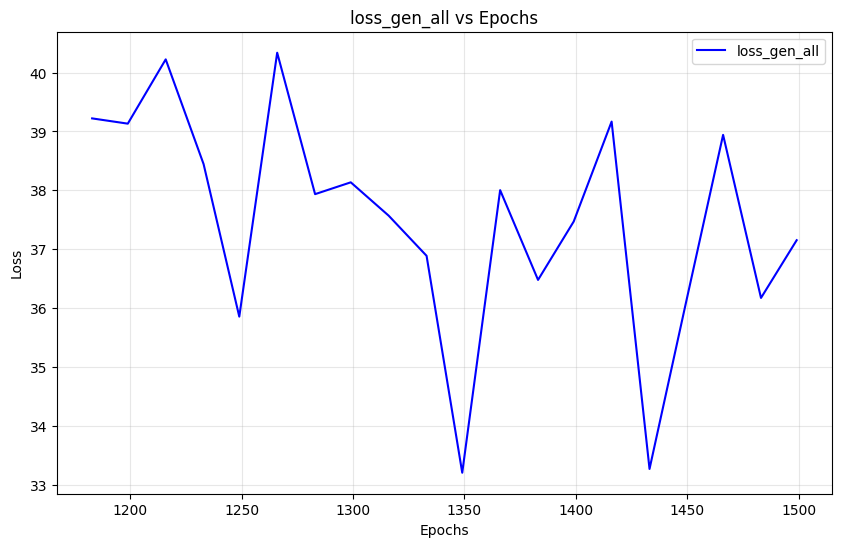

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 1. Define path to your specific log version
log_dir = "training_dir_reva/lightning_logs/version_0"

# Automatically find the event file
event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
if not event_files:
    print(f"No event files found in {log_dir}")
else:
    event_path = os.path.join(log_dir, event_files[0])
    print(f"Reading logs from: {event_path}")

    # Load the data
    ea = EventAccumulator(event_path)
    ea.Reload()
    
    # Get available metrics
    tags = ea.Tags()['scalars']
    
    # 2. Identify which Loss to plot
    # Prioritize 'val_loss' (or similar), otherwise fallback to training loss
    val_loss_tags = [t for t in tags if "val" in t and "loss" in t]
    train_loss_tags = [t for t in tags if "loss_gen" in t or "g_loss" in t] # Generator loss is usually main metric
    
    if val_loss_tags:
        metric_name = val_loss_tags[0]
        print(f"Plotting Metric: {metric_name}")
    elif train_loss_tags:
        print("⚠️ Validation loss not found (validation_split might be 0). Plotting Training Loss instead.")
        metric_name = train_loss_tags[0]
    else:
        # Fallback to any scalar with 'loss' in it
        any_loss = [t for t in tags if "loss" in t]
        metric_name = any_loss[0] if any_loss else None

    # 3. Plot
    if metric_name:
        # Extract Loss values
        data_events = ea.Scalars(metric_name)
        y_values = [x.value for x in data_events]
        steps = [x.step for x in data_events]

        # Extract Epoch values to use as X-axis
        if 'epoch' in tags:
            epoch_events = ea.Scalars('epoch')
            step_to_epoch = {e.step: e.value for e in epoch_events}
            
            # Map the steps of our loss metric to their corresponding epoch
            # If exact step match misses, it usually means 'epoch' is logged less frequently, 
            # so we'll approximate or just use step if needed.
            x_values = []
            for s in steps:
                # Find closest logged epoch
                closest_step = min(step_to_epoch.keys(), key=lambda k: abs(k-s))
                x_values.append(step_to_epoch[closest_step])
            
            x_label = "Epochs"
        else:
            x_values = steps
            x_label = "Steps"

        plt.figure(figsize=(10, 6))
        plt.plot(x_values, y_values, label=metric_name, color='blue')
        plt.xlabel(x_label)
        plt.ylabel("Loss")
        plt.title(f"{metric_name} vs {x_label}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No loss metrics found to plot. Available tags:", tags)